
#### Environment Set-up 



In [1]:
begin
	# Activate project environment
	import Pkg
	Pkg.activate(".")
	
	# SciML tools
	import ModelingToolkit, Symbolics
	
	# Standard libraries
	using StatsBase, Plots, CSV, DataFrames
	
    # External libraries
	using HyperTuning, StableRNGs, Distributions, SmoothingSplines, ColorSchemes, JLD2, ProgressLogging
	
    # Data Driven Equation Discovery packages
	using DataDrivenDiffEq, DataDrivenSparse
	
    # Import utils function
	include("esindy_utils.jl")
	import .ESINDyModule
	using .ERKModule
	using .NFBModule
	
	# Set a random seed for reproducibility
	rng = StableRNG(1111)
	gr()
end

  Activating project at `~/Documents/Master/MasterThesis/UDE/DataDrivenEquationDiscovery`


Plots.GRBackend()


# Equation discovery with E-SINDy
This notebook contains the code to implement a version of the E-SINDy algorithms inspired from "Discovering governing equations from data by sparse identification of nonlinear dynamical systems" by Brunton et al. (2016), [DOI](https://doi.org/10.1098/rspa.2021.0904). It was designed to estimate the algebraic formula of an unknown function. In this work, the function corresponds to unknown parts of an ODE system that were approximated by a neural network. A theoretical negative feedback model of two kinases g1p and g2p presented in "Quantitative Biology: Theory, Computational Methods and Examples of Models" was used to generate the data.  

Reference: Chapter 13: Parameter Estimation, Sloppiness, and Model Identifiability by D. Daniels, M. Dobrzyński, D. Fey (2018) in "Quantitative Biology: Theory, Computational Methods and Examples of Models".




#### Import the data



In [2]:
# Create E-SINDy compatible data structure out of dataframes
function create_nfb_data(files, smoothing=0.)
	
    # Load data into dataframe
	df = CSV.read("../Data/$(files[1])", DataFrame)
	if length(files) > 1
	    for i in 2:length(files)
	        df2 = CSV.read("../Data/$(files[i])", DataFrame)
	        df = vcat(df, df2)
	    end
	end
	
    # Create labels for plotting and retrieve NFB case
	labels, case = NFBModule.make_labels(files)
	
    # Retrieve the number of samples
	n_samples = sum(df.time .== 0)
	size_sample = Int(nrow(df) / n_samples)
	
    # Define relevant data for E-SINDy
	time = df.time
	X = [df.g1p_fit df.g2p_fit df.Xact_fit]
	Y = [df.NN1 df.NN2]
	
    # Smooth the NN approximation if necessary
	if smoothing != 0 
		smoothed_Y1 = smooth_nn_output(time, df.NN1, n_samples, size_sample, smoothing)
		smoothed_Y2 = smooth_nn_output(time, df.NN2, n_samples, size_sample, smoothing)
		Y = [smoothed_Y1 smoothed_Y2]
	end
	
    GT = 0
	if case == "a"
		GT = [df.Xact_fit repeat([1], size(df.Xact_fit, 1))]
	elseif case == "b"
		GT = [repeat([1], size(df.Xact_fit, 1)) df.Xact_fit]
	elseif case == "nofb"
		GT = [repeat([1], size(time, 1)) repeat([1], size(time, 1))]
	elseif case == "ab"
		GT = [df.Xact_fit df.Xact_fit]
	end
	@assert size(X, 1) == size(Y, 1)
		
	return (time=time, X=X, Y=Y, GT=GT, labels=labels, case=case)
end

create_nfb_data (generic function with 2 methods)

In [7]:
begin
	# Load the NFB model estimations for various concentrations
	nofb_files = ["nfb_nofb_001.csv" "nfb_nofb_002.csv" "nfb_nofb_003.csv" "nfb_nofb_004.csv" "nfb_nofb_005.csv" "nfb_nofb_006.csv" "nfb_nofb_007.csv" "nfb_nofb_008.csv" "nfb_nofb_009.csv"]
	nofb_data = create_nfb_data(nofb_files)
    
	a_files = ["nfb_a_001.csv" "nfb_a_002.csv" "nfb_a_003.csv" "nfb_a_004.csv" "nfb_a_005.csv" "nfb_a_006.csv" "nfb_a_007.csv" "nfb_a_008.csv" "nfb_a_009.csv"]
	a_data = create_nfb_data(a_files)
    
    b_files = ["nfb_b_001.csv" "nfb_b_002.csv" "nfb_b_003.csv" "nfb_b_004.csv" "nfb_b_005.csv" "nfb_b_006.csv" "nfb_b_007.csv" "nfb_b_008.csv" "nfb_b_009.csv"]
	b_data = create_nfb_data(b_files)

    ab_files = ["nfb_ab_001.csv" "nfb_ab_002.csv" "nfb_ab_003.csv" "nfb_ab_004.csv" "nfb_ab_005.csv" "nfb_ab_006.csv" "nfb_ab_007.csv" "nfb_ab_008.csv" "nfb_ab_009.csv"]
	ab_data = create_nfb_data(ab_files)
end

(time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 0.0; 0.0005669736642950376 0.0001611316319602873 3.3572652630638765e-7; … ; 0.0012426335650559102 0.05252321509326248 0.6131669331781431; 0.0012439029220164641 0.052483810462326856 0.6126282082250685], Y = [0.0007674903847895386 0.02286681437951664; 0.0006314265581752287 0.02274754419646494; … ; 0.6663666582040932 0.5751984134970839; 0.6656948309477175 0.57467704186535], GT = [0.0 0.0; 3.3572652630638765e-7 3.3572652630638765e-7; … ; 0.6131669331781431 0.6131669331781431; 0.6126282082250685 0.6126282082250685], labels = Any["Input CC 0.01", "Input CC 0.02", "Input CC 0.03", "Input CC 0.04", "Input CC 0.05", "Input CC 0.06", "Input CC 0.07", "Input CC 0.08", "Input CC 0.09"], case = "ab")


#### Set up the SINDy library of functions



In [8]:
begin
	# Declare necessary symbolic variables for the bases
	@ModelingToolkit.variables x[1:3] i[1:1]
	x = collect(x)
	i = collect(i)
end

1-element Vector{Num}:
 i[1]

In [9]:
begin
	# Define a basis of functions to estimate the unknown equation of NFB model
	nfb_h = DataDrivenDiffEq.monomial_basis(x[1:3], 2)
	nfb_basis = DataDrivenDiffEq.Basis(nfb_h, x[1:3])
end

Model ##Basis#226 with 7 equations
Unknowns (3):
  x[1]
  x[2]
  x[3]
Parameters (0):


#### Set up the hyperparameter optimisation



In [10]:
begin
	# Define a sampling method and the options for the data driven problem
	sampler = DataDrivenDiffEq.DataProcessing(split = 0.8, shuffle = true, batchsize = 400)
	options = DataDrivenDiffEq.DataDrivenCommonOptions(data_processing = sampler, digits=1, abstol=1e-10, reltol=1e-10, denoise=true)
end

DataDrivenCommonOptions{Float64, @NamedTuple{}}
  maxiters: Int64 100
  abstol: Float64 1.0e-10
  reltol: Float64 1.0e-10
  progress: Bool false
  verbose: Bool false
  denoise: Bool true
  normalize: DataNormalization{Nothing} DataNormalization{Nothing}()
  data_processing: DataProcessing
  roundingmode: RoundingMode{:ToZero} RoundingMode{:ToZero}()
  digits: Int64 1
  selector: bic (function of type typeof(bic))
  generate_symbolic_parameters: Bool true
  eval_expresssion: Bool false
  kwargs: @NamedTuple{} NamedTuple()


In [11]:
# Define an objective function for hyperparameter optimisation
function objective(trial, dd_prob, basis, with_implicits)
	@unpack λ, ν = trial
	
    if with_implicits
		res_dd = DataDrivenDiffEq.solve(
			dd_prob, 
			basis, 
			ImplicitOptimizer(DataDrivenSparse.SR3(λ, ν)), 
			options = options)
	else
		res_dd = DataDrivenDiffEq.solve(
			dd_prob, 
			basis, 
			DataDrivenSparse.SR3(λ, ν), 
			options = options)
	end
	
	return bic(res_dd)
end

objective (generic function with 1 method)

In [12]:
# Hyperparameter optimisation function
function get_best_hyperparameters(dd_prob, basis, with_implicits)
	
    # Define the range of hyperparameters to consider
	scenario = Scenario(λ = 1e-3:1e-3:9e-1, ν = exp10.(-3:1:3), max_trials = 500, 
		sampler=HyperTuning.RandomSampler())
	
    # Find optimal hyperparameters
	hp_res = HyperTuning.optimize(trial -> objective(trial, dd_prob, basis, with_implicits), scenario)
	return hp_res.best_trial.values[:λ], hp_res.best_trial.values[:ν]
end

get_best_hyperparameters (generic function with 1 method)


#### E-SINDy Utility Functions



In [13]:
# Bootstrapping function that estimate optimal library coefficients given data
function sindy_bootstrap(data, basis, n_bstraps, data_fraction)
	
    # Initialise the coefficient array
	n_eqs = size(data.Y, 2)
	l_basis = length(basis)
	bootstrap_coef = zeros(n_bstraps, n_eqs, l_basis)
	
    # Track best hyperparameters
	hyperparam = (λ = [], ν = [])
	@info "E-SINDy Bootstrapping:"
	@progress name="Bootstrapping" threshold=0.01 for i in 1:n_bstraps
		
        # Sample data from the sets of measurements
		rand_ind = rand(1:(length(data.time)), floor(Int, length(data.time) * data_fraction))
		X = data.X[rand_ind,:]
		Y = data.Y[rand_ind,:]
		
        # Check if the problem involves implicits
		implicits = implicit_variables(basis)
		with_implicits = false
		if !isempty(implicits)
			with_implicits = true
		end
		
		if with_implicits
			for eq in 1:n_eqs
				dd_prob = DataDrivenDiffEq.DirectDataDrivenProblem(X', Y[:,eq:eq]')
				
				# Solve problem with optimal hyperparameters
				best_λ, best_ν = get_best_hyperparameters(dd_prob, basis, with_implicits)
				push!(hyperparam.λ, best_λ)
				push!(hyperparam.ν, best_ν)
				
				best_res = DataDrivenDiffEq.solve(dd_prob, basis, ImplicitOptimizer(DataDrivenSparse.SR3(best_λ, best_ν)), options=options)
				
                # Simplify the symbolic expression to get the final coefficients
				simpl_coefs = ESINDyModule.simplify_expression(best_res.out[1].coefficients[1,:], basis)
				
				# Store library coefficient for current bootstrap
				bootstrap_coef[i,eq,:] = simpl_coefs
			end
		else
			dd_prob = DataDrivenDiffEq.DirectDataDrivenProblem(X', Y')
			
			# Solve problem with optimal hyperparameters
			best_λ, best_ν = get_best_hyperparameters(dd_prob, basis, with_implicits)
			push!(hyperparam.λ, best_λ)
			push!(hyperparam.ν, best_ν)
			best_res = DataDrivenDiffEq.solve(dd_prob, basis, DataDrivenSparse.SR3(best_λ, best_ν), options = options)
			
			# Store library coefficient for current bootstrap
			bootstrap_coef[i,:,:] = best_res.out[1].coefficients
		end	
	end
	return bootstrap_coef, hyperparam
end

sindy_bootstrap (generic function with 1 method)

In [14]:
# Function to identify the candidate equations returned during E-SINDy
function get_coef_mask(bootstraps)
	
	# Repeat for each equation
	n_eqs = size(bootstraps, 2)
	eq_masks = []
	for eq in 1:n_eqs
		
        # Initialise set of masks
		masks = []
		mask_set = Set()
		
        # Define mask corresponding to non-zero coefficients
		n_bootstraps = size(bootstraps, 1)
		for k in 1:n_bootstraps
			mask = (!iszero).(bootstraps[k,eq:eq,:])
			if mask in mask_set
				nothing
			else
				
                # Compute the frequency of current mask
				push!(mask_set, mask)
				freq = 0
				coefs = []
				for j in k:n_bootstraps
					temp_mask = (!iszero).(bootstraps[j,eq:eq,:])
					if isequal(mask, temp_mask)
						push!(coefs, bootstraps[j,eq:eq,:])
						freq = freq + 1
					end
				end
				
                # Compute mean and std of the coefficients of current mask
				coef_std = std(coefs)
				if any(isnan, coef_std)
					nothing
				else
					push!(masks, (mask=mask, freq=freq/n_bootstraps, coef_mean=mean(coefs), coef_std=coef_std/sqrt(n_bootstraps)))
				end
			end
		end
		push!(eq_masks, masks)
	end
	return eq_masks
end

get_coef_mask (generic function with 1 method)

In [15]:
# Function to estimate coefficient statistics
function compute_ecoef(bootstrap_res, coef_threshold)
	
    # Retrieve dimensions of the problem
	sample_size = size(bootstrap_res, 1)
	n_eqs = size(bootstrap_res, 2)
	n_terms = size(bootstrap_res, 3)
	
    # Compute inclusion probabilities
	inclusion_prob = (mean((bootstrap_res .!= 0), dims=1) * 100)
	
    # Keep only elements of basis with probabilities above threshold
	mask = inclusion_prob .> coef_threshold
	masked_res = bootstrap_res .* mask
	
    # Compute the mean 
	m = zeros(Float64, n_eqs, n_terms)
	for i in 1:n_eqs
		for j in 1:n_terms
			current_coef = filter(!iszero, masked_res[:,i,j])
			if !isempty(current_coef)
				m[i,j] = median(current_coef) 
			end
		end
	end
	return m
end

compute_ecoef (generic function with 1 method)

In [16]:
# Function to compute the interquartile range of the estimated equation
function compute_CI(data, basis, masks, ecoef_mask)
	
	# Run MC simulations to estimate the distribution of estimated equations 
	n_eqs = size(data.Y, 2)
	n_simulations = 1000
	results = zeros(n_simulations, size(data.Y, 1), n_eqs) 
	for eq in 1:n_eqs
		
        # Keep only mask that share coefficient with the median coefficient
		up_masks = [mask for mask in masks[eq] if any(mask.mask .== ecoef_mask[eq:eq,:])]
		freqs = Weights([mask.freq for mask in up_masks])
		
		for i in 1:n_simulations			
			current_coef = zeros(size(up_masks[1].coef_mean))
			mask = sample(up_masks, freqs)
			current_mask = mask.mask .& ecoef_mask[eq:eq,:]
			
			# Build Normal distribution for non-zero coefficients
			indices = findall(!iszero, current_mask)
			mask.coef_std[iszero.(mask.coef_std)] .= 1e-12
			coef_distrib = [Normal(mask.coef_mean[k], mask.coef_std[k]) for k in indices]
	
			# Samples coefficient from the distribution
			coef_sample = [rand(distrib) for distrib in coef_distrib]
			current_coef[indices] = coef_sample
	
			# Calculate function value given sample of coef.
			current_eqs = ESINDyModule.build_equations(current_coef, basis, verbose=false)
			yvals = ESINDyModule.get_yvals(data, current_eqs)
			results[i,:,eq] = yvals[1]
		end
	end
	iqr_low = mapslices(row -> percentile(filter(!isnan, row), 25), results, dims=1)
	iqr_up = mapslices(row -> percentile(filter(!isnan, row), 75), results, dims=1)
    return (iqr_low=iqr_low[1,:,:], iqr_up=iqr_up[1,:,:])
end

compute_CI (generic function with 1 method)

In [17]:
# Plotting function for E-SINDy results
function plot_esindy(results; sample_idxs=nothing, iqr=true)
	
    # Retrieve results
	data, basis = results.data, results.basis
	coef_median = results.coef_median
	
	eqs = ESINDyModule.build_equations(coef_median, basis, verbose=false)
	y_vals = ESINDyModule.get_yvals(data, eqs)
	
    # Retrieve the indices of samples to plot
	n_samples = sum(data.time .== 0)
	size_sample = Int(length(data.time) / n_samples)
	if isnothing(sample_idxs)
		sample_idxs = 1:n_samples
	end
	
    # Compute interquartile range if necessary
	ci_low, ci_up = nothing, nothing
	if iqr
		ecoef_mask = (!iszero).(coef_median)
		ci_low, ci_up = compute_CI(data, basis, results.masks, ecoef_mask)
	end
	
	# Plot results
	n_eqs = size(eqs, 1)
	subplots = []
	palette = colorschemes[:seaborn_colorblind]
	for eq in 1:n_eqs
		
		i_color = 1
		if n_eqs > 1
			p = plot(title="Equation $(eq)", xlabel="Time t", ylabel="Equation y(t)")
		else
			p = plot(title="", xlabel="Time", ylabel="Equation y(t)")
		end
		
        # Plot each sample separately
		for sample in 0:(n_samples-1)
			if (sample+1) in sample_idxs
				i_start = 1 + sample * size_sample
				i_end = i_start + size_sample - 1
				
				y = y_vals[eq][i_start:i_end] 
				if iqr
					plot!(p, data.time[i_start:i_end], y, label=data.labels[sample+1], color=palette[i_color],
					ribbon=(y - ci_low[i_start:i_end, eq], ci_up[i_start:i_end, eq] - y), fillalpha=0.15)
				else
					plot!(p, data.time[i_start:i_end], y, label=data.labels[sample+1], color=palette[i_color])
				end
				
				plot!(p, data.time[i_start:i_end], data.GT[i_start:i_end, eq], label="", linestyle=:dash, color=palette[i_color])
				i_color = i_color + 1
			end
		end
		plot!(p, [], [],  label="GT", color=:black, linestyle=:dash)
		push!(subplots, p)
	end
	return subplots
end

plot_esindy (generic function with 1 method)

In [18]:
# Complete E-SINDy function 
function esindy(data, basis, n_bstrap=100; coef_threshold=65, data_fraction=1)
	
    # Run sindy bootstraps
	bootstrap_res, hyperparameters = sindy_bootstrap(data, basis, n_bstrap, data_fraction)
	
    # Compute the masks
	masks = get_coef_mask(bootstrap_res)
	
	# Compute the mean and std of ensemble coefficients
	e_coef = compute_ecoef(bootstrap_res, coef_threshold)
	
    # Build the final equation as callable functions
	println("E-SINDy estimated equations:")
	y = ESINDyModule.build_equations(e_coef, basis)
	
	return (data=data, 
	basis=basis, 
	bootstraps=bootstrap_res, 
	coef_median=e_coef, 
	hyperparameters=hyperparameters, 
	masks=masks)
end

esindy (generic function with 2 methods)


### NFB results




#### Case a




##### Run E-SINDy



In [19]:
#a_res = esindy(a_data, nfb_basis, 100, coef_threshold=85, data_fraction=0.5)


##### Save or load the results (JLD2 file)



In [20]:
begin
	#jldsave("../Data/nfb_esindy_100bt_a.jld2"; results=a_res)
	a_res = load("../Data/nfb_esindy_100bt_a.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 0.0; 0.0005489117081383326 0.000159416014883943 3.330374424796105e-7; … ; 0.001945536392042614 0.039496180726477696 0.42687407860352183; 0.0019471024739820507 0.0395403885579647 0.42654252267336773], Y = [0.011126652263077907 -0.8387490167572195; 0.01113999617211956 -0.8389170743520586; … ; 0.4285176004539152 0.9956284333228911; 0.4281794775093314 0.9956242426294716], GT = [0.0 1.0; 3.330374424796105e-7 1.0; … ; 0.42687407860352183 1.0; 0.42654252267336773 1.0], labels = Any["Input CC 0.01", "Input CC 0.02", "Input CC 0.03", "Input CC 0.04", "Input CC 0.05", "Input CC 0.06", "Input CC 0.07", "Input CC 0.08", "Input CC 0.09"], case = "a"), basis = Basis{false, false}(Equation[φ₁ ~ 1, φ₂ ~ x[1], φ₃ ~ x[1]^2, φ₄ ~ x[2], φ₅ ~ x[2]^2, φ₆ ~ x[3], φ₇ ~ x[3]^2], SymbolicUtils.BasicSymbolic{Real}[x[1], x[2], x[3]], Any[], Any[],


##### Plot the results



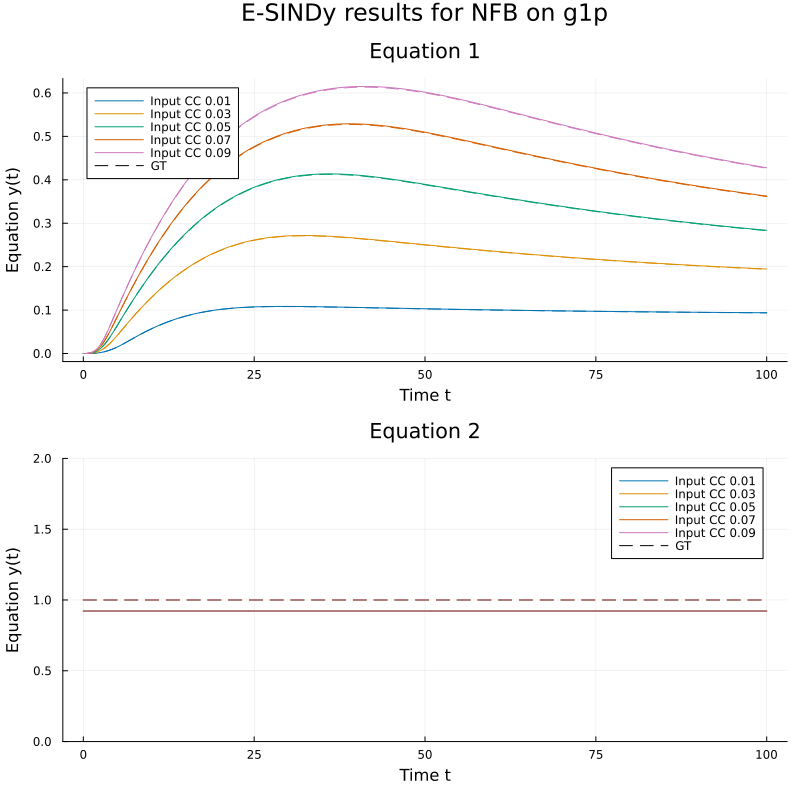

In [21]:
begin
	# Plot the results
	a_plots = plot_esindy(a_res, sample_idxs=1:2:9, iqr=false)
	a_plot2 = plot(a_plots[2], ylim=(0, 2))
	plot(a_plots[1], a_plot2, layout=(2,1), size=(800, 800), plot_title="E-SINDy results for NFB on g1p")
	#savefig("../Plots/NFB_esindy_a.svg")
end


#### Case b




##### Run E-SINDy



In [22]:
#b_res = esindy(b_data, nfb_basis, 100, coef_threshold=85, data_fraction=0.5)


##### Save or load the results (JLD2 file)



In [23]:
begin
	#jldsave("../Data/nfb_esindy_100bt_b.jld2"; results=b_res)
	b_res = load("../Data/nfb_esindy_100bt_b.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 0.0; 9.084792169051417e-5 4.344842305037503e-5 1.1806379104610375e-7; … ; 0.0008296277824864954 0.10662549448017715 0.317660179139808; 0.0008296281523569588 0.10647339530680874 0.31781539328997], Y = [0.9996175146486037 -0.003541157165205822; 0.9996175141388006 -0.003544774159792044; … ; 0.9943101866281402 0.31961219688191445; 0.9943097474197543 0.3197650561416133], GT = [1.0 0.0; 1.0 1.1806379104610375e-7; … ; 1.0 0.317660179139808; 1.0 0.31781539328997], labels = Any["Input CC 0.01", "Input CC 0.02", "Input CC 0.03", "Input CC 0.04", "Input CC 0.05", "Input CC 0.06", "Input CC 0.07", "Input CC 0.08", "Input CC 0.09"], case = "b"), basis = Basis{false, false}(Equation[φ₁ ~ 1, φ₂ ~ x[1], φ₃ ~ x[1]^2, φ₄ ~ x[2], φ₅ ~ x[2]^2, φ₆ ~ x[3], φ₇ ~ x[3]^2], SymbolicUtils.BasicSymbolic{Real}[x[1], x[2], x[3]], Any[], Any[], Any[]


##### Plot the results



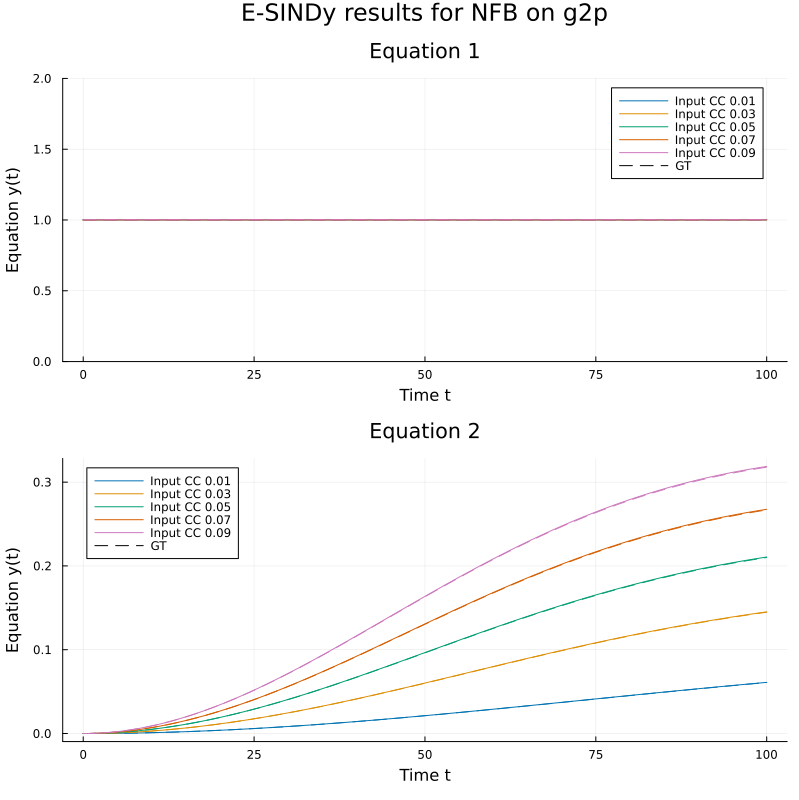

In [24]:
begin
	# Plot the results
	b_plots = plot_esindy(b_res, sample_idxs=1:2:9, iqr=false)
	b_plot1 = plot(b_plots[1], ylim=(0, 2))
	plot(b_plot1, b_plots[2], layout=(2,1), size=(800, 800), plot_title="E-SINDy results for NFB on g2p")
	#savefig("../Plots/nfb_esindy_b.svg")
end


#### Case ab




##### Run E-SINDy



In [25]:
#ab_res = esindy(ab_data, nfb_basis, 100, coef_threshold=85, data_fraction=0.5)


##### Save or load the results (JLD2 file)



In [25]:
begin
	#jldsave("../Data/nfb_esindy_100bt_ab.jld2"; results=ab_res)
	ab_res = load("../Data/nfb_esindy_100bt_ab.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 0.0; 0.0005669736642950376 0.0001611316319602873 3.3572652630638765e-7; … ; 0.0012426335650559102 0.05252321509326248 0.6131669331781431; 0.0012439029220164641 0.052483810462326856 0.6126282082250685], Y = [0.0007674903847895386 0.02286681437951664; 0.0006314265581752287 0.02274754419646494; … ; 0.6663666582040932 0.5751984134970839; 0.6656948309477175 0.57467704186535], GT = [0.0 0.0; 3.3572652630638765e-7 3.3572652630638765e-7; … ; 0.6131669331781431 0.6131669331781431; 0.6126282082250685 0.6126282082250685], labels = Any["Input CC 0.01", "Input CC 0.02", "Input CC 0.03", "Input CC 0.04", "Input CC 0.05", "Input CC 0.06", "Input CC 0.07", "Input CC 0.08", "Input CC 0.09"], case = "ab"), basis = Basis{false, false}(Equation[φ₁ ~ 1, φ₂ ~ x[1], φ₃ ~ x[1]^2, φ₄ ~ x[2], φ₅ ~ x[2]^2, φ₆ ~ x[3], φ₇ ~ x[3]^2], SymbolicUtils.B


##### Plot the results



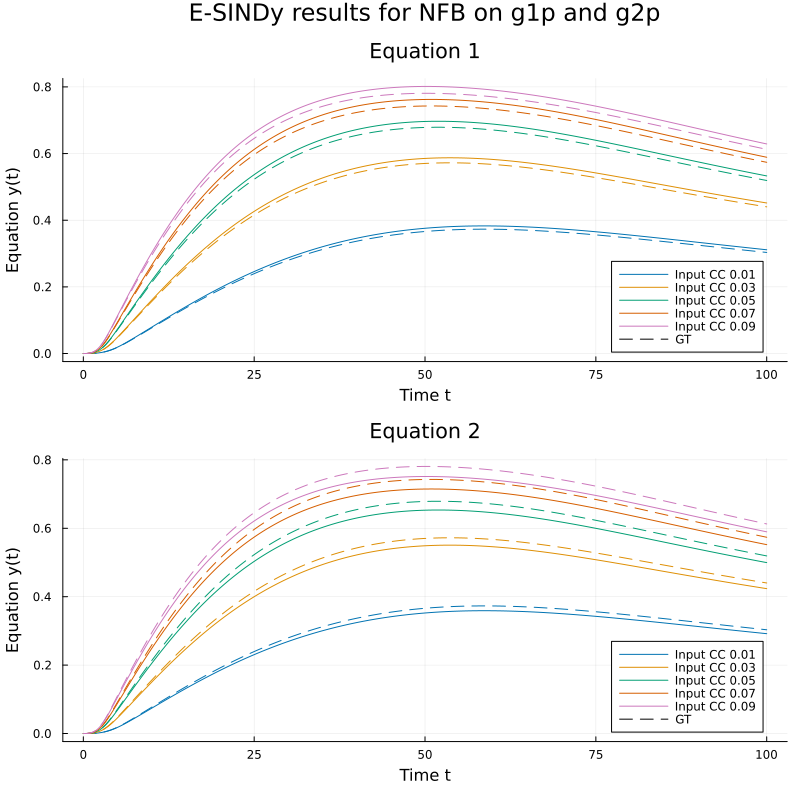

In [26]:
begin
	# Plot the results
	ab_plots = plot_esindy(ab_res, sample_idxs=1:2:9, iqr=false)
	plot(ab_plots[1], ab_plots[2], layout=(2,1), size=(800, 800), plot_title="E-SINDy results for NFB on g1p and g2p")
	#savefig("../Plots/nfb_esindy_ab.svg")
end


#### Case no FB




##### Run E-SINDy



In [29]:
#nofb_res = esindy(nofb_data, nfb_basis, 100, coef_threshold=85, data_fraction=0.5)


##### Save or load the results (JLD2 file)



In [31]:
begin
	#jldsave("../Data/nfb_esindy_100bt_nofb.jld2"; results=nofb_res)
	nofb_res = load("../Data/nfb_esindy_100bt_nofb.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 0.0; 8.077167e-5 3.8831415e-5 1.07384764e-7; … ; 0.0008264575618857511 0.01425983312832891 0.043338206975048636; 0.0008264576924407284 0.014259833551900697 0.043371396583299526], Y = [1.1254054280252346 0.8844334590826063; 1.125405479767856 0.8844333007873068; … ; 0.998093228209877 1.0020389557225524; 0.9980930718541139 1.0020390888414403], GT = [1 1; 1 1; … ; 1 1; 1 1], labels = Any["Input CC 0.01", "Input CC 0.02", "Input CC 0.03", "Input CC 0.04", "Input CC 0.05", "Input CC 0.06", "Input CC 0.07", "Input CC 0.08", "Input CC 0.09"], case = "nofb"), basis = Basis{false, false}(Equation[φ₁ ~ 1, φ₂ ~ x[1], φ₃ ~ x[1]^2, φ₄ ~ x[2], φ₅ ~ x[2]^2, φ₆ ~ x[3], φ₇ ~ x[3]^2], SymbolicUtils.BasicSymbolic{Real}[x[1], x[2], x[3]], Any[], Any[], Any[], t, Any[], DataDrivenDiffEq.DataDrivenFunction{false, false, RuntimeGeneratedFuncti


##### Plot the results



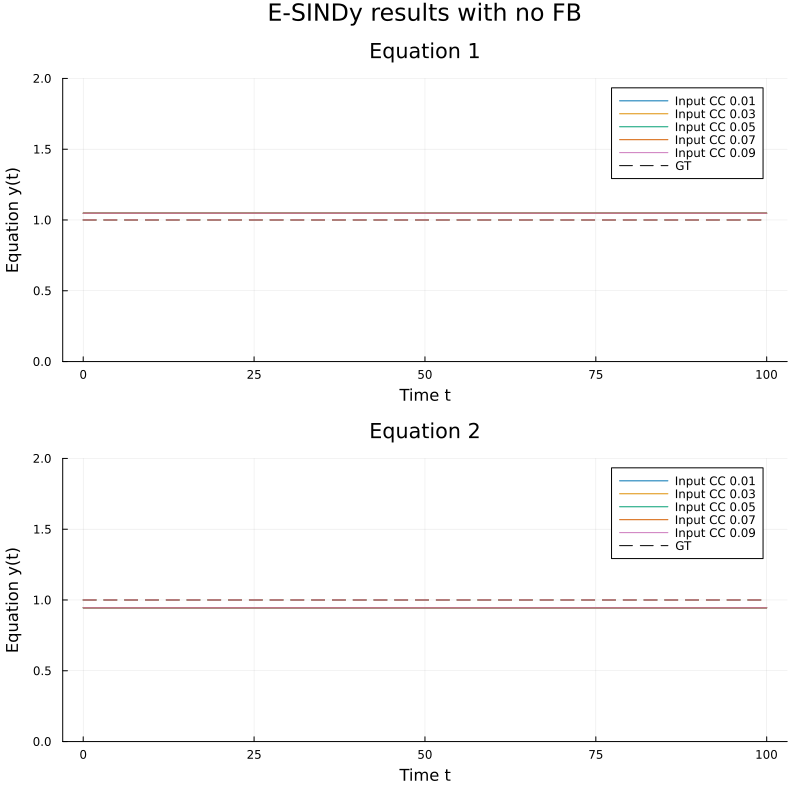

In [32]:
begin
	# Plot the results
	nofb_plots = plot_esindy(nofb_res, sample_idxs=1:2:9, iqr=false)
	plot(nofb_plots[1], nofb_plots[2], ylim=(0, 2), layout=(2,1), size=(800, 800), plot_title="E-SINDy results with no FB")
	#savefig("../Plots/nfb_esindy_nofb.svg")
end